In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# Imported Interbank FX Rates Historical.csv
Interbank_FX_Rates_Historical = pd.read_csv('./datasets/Interbank FX Rates Historical.csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns GBPGHS
Interbank_FX_Rates_Historical.rename(columns={'Selling': 'GBPGHS'}, inplace=True)

In [3]:
# Imported Interbank FX Rates Historical (1).csv
Interbank_FX_Rates_Historical_1 = pd.read_csv('./datasets/Interbank FX Rates Historical (1).csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical_1.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns USDGHS
Interbank_FX_Rates_Historical_1.rename(columns={'Selling': 'USDGHS'}, inplace=True)

In [4]:
# Merged Interbank_FX_Rates_Historical_1 and Interbank_FX_Rates_Historical into df3
temp_df = Interbank_FX_Rates_Historical.drop_duplicates(subset=['Date']) # Remove duplicates so lookup merge only returns first match
df = Interbank_FX_Rates_Historical_1.merge(temp_df, left_on=['Date'], right_on=['Date'], how='left', suffixes=['_Interbank_FX_Rates_Historical_1', '_Interbank_FX_Rates_Historical'])
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [5]:
# Check for missing values
print('missing values:', df.isnull().sum().sort_values(ascending = False))

missing values: Date      0
USDGHS    0
GBPGHS    0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3226 non-null   object
 1   USDGHS  3226 non-null   object
 2   GBPGHS  3226 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


In [7]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


In [8]:
df_plot = df.copy()
df.head()

,USDGHS,GBPGHS
Date,,
2008-01-02,1.9427,0.9799
2008-01-03,1.9394,0.9799
2008-01-04,1.9309,0.9798
2008-01-05,1.9309,0.9798
2008-01-06,1.9309,0.9798


<AxesSubplot:xlabel='Date'>

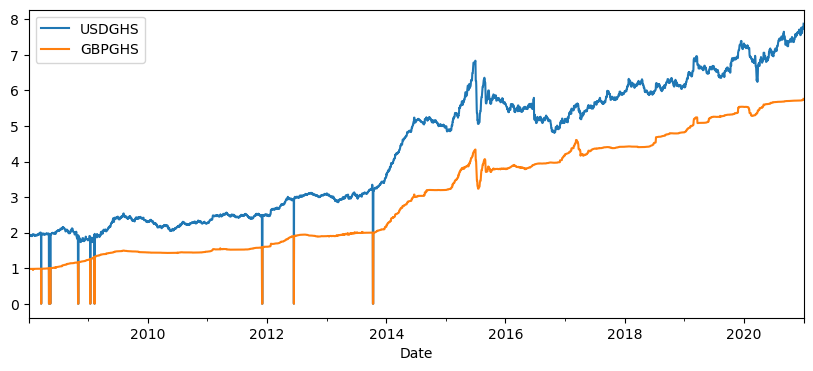

In [9]:
# Let's see a historical view of the closing Rate
df_plot['USDGHS'].plot(legend=True, figsize=(10,4))
df_plot['GBPGHS'].plot(legend=True, figsize=(10,4))

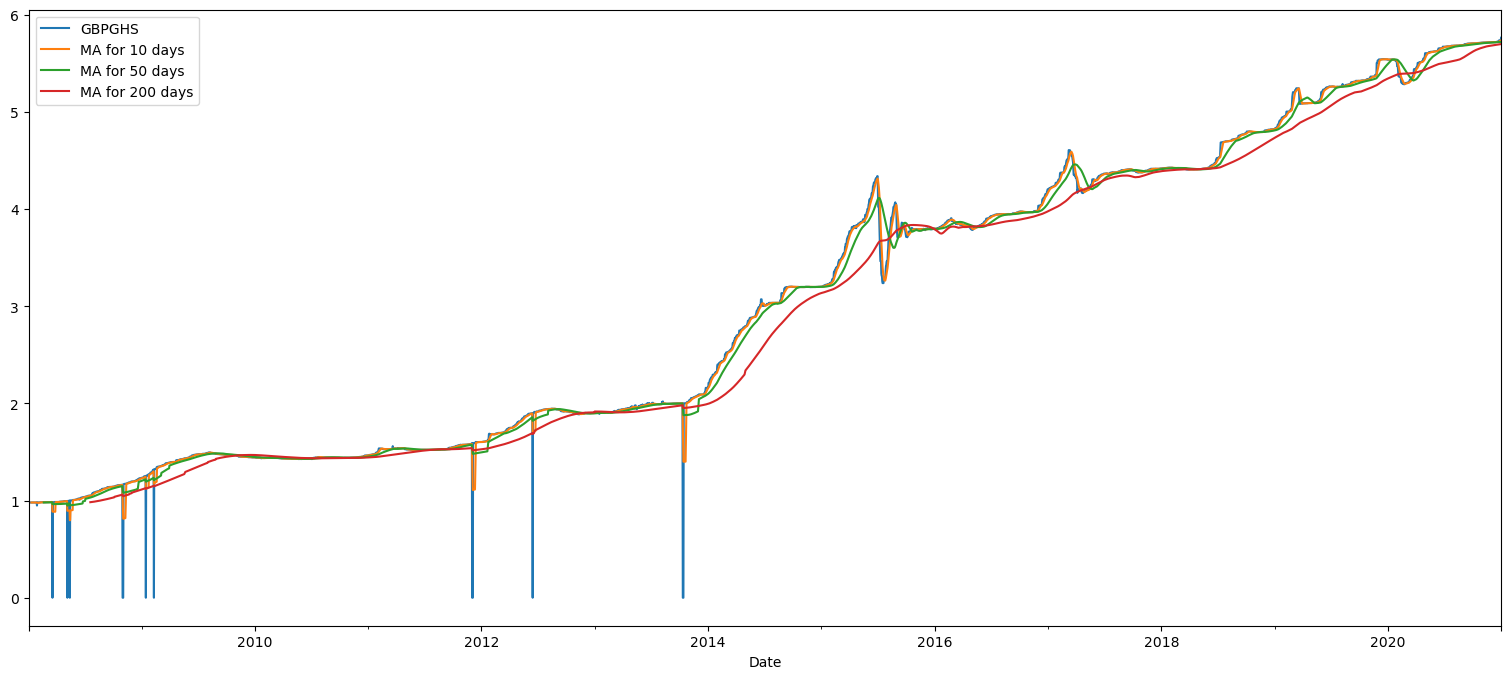

In [10]:
# Let's go ahead and plot out several moving averages
MA_day = [10,50,200]

for ma in MA_day:
    column_name = 'MA for %s days' %(str(ma))
    df_plot[column_name] = df_plot['GBPGHS'].rolling(window=ma).mean()
df_plot = df_plot[['GBPGHS','MA for 10 days','MA for 50 days','MA for 200 days']].plot(subplots=False,figsize=(19,8))

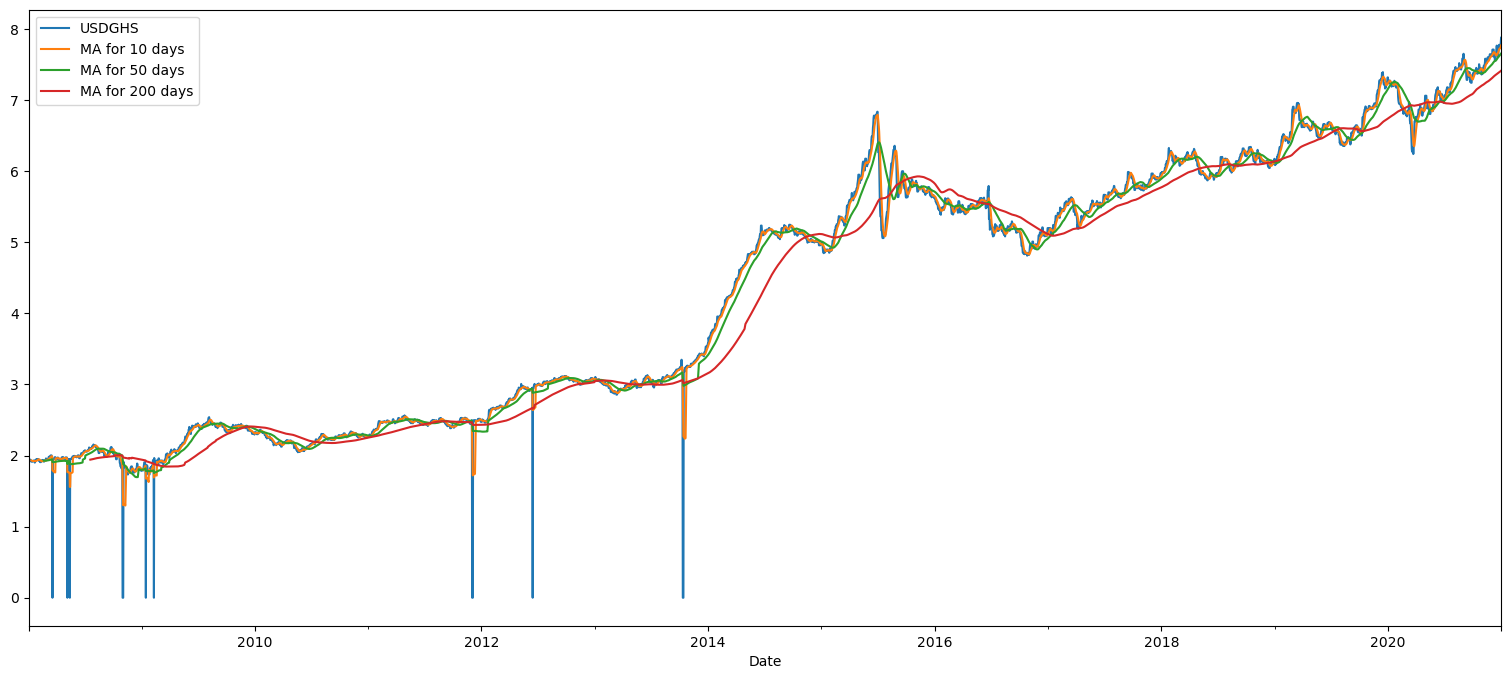

In [11]:
GBPGHS = df['GBPGHS']
GBPGHS.to_csv('datasets/GBPGHS.csv')
GBPGHS.head()

Date
2008-01-02    0.9799
2008-01-03    0.9799
2008-01-04    0.9798
2008-01-05    0.9798
2008-01-06    0.9798
Freq: D, Name: GBPGHS, dtype: float64

It is not necessary to check for autocorrelation in time series before using LSTM. However, it is important to check for autocorrelation in time series data before using any time series model. Autocorrelation is a measure of the correlation between the values of a time series at different points in time. If there is autocorrelation in the data, it means that the values of the time series at one point in time are correlated with the values at other points in time. This can lead to biased estimates of the model parameters and can affect the accuracy of the model predictions

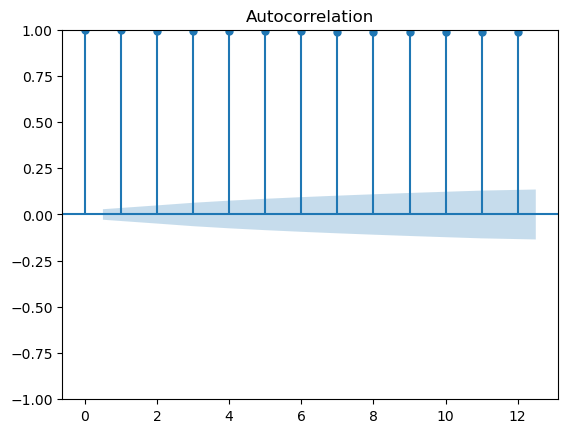

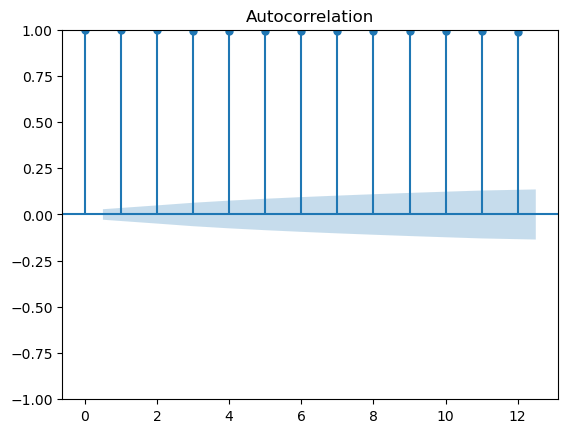

In [13]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(df["USDGHS"], lags=12)
fig = tsaplots.plot_acf(df["GBPGHS"], lags=12)
plt.show()

In [12]:
print('the shape of the  dataset is ', GBPGHS.shape)

the shape of the  dataset is  (4748,)


### Transforming the time series into well labelled training and testing dataset 

We will use the following function to transform time series into well labelled braining training and target samples. i.e we transform out input into a tuple (n_samples,n_timesteps,n_features)

In [13]:
def Model_data_setup(data, lookback, delay, min_index, max_index):
    """
    data:     Shape (n_samples, n_features). First column is the time series, other columns are the features.
              If there is only one column, it is assumed to be the time series data.
    lookback: Number of time steps in the Model >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x, y) of numpy arrays where x is in shape (n_samples, n_timesteps, n_features) and 
             y is in shape (n_samples, delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    """
    if data.ndim == 1:
        data = np.expand_dims(data, axis=1)
    n_samples = max_index - lookback - delay + 1
    x_shape = (n_samples, lookback, data.shape[1])
    x = np.zeros(x_shape)
    y_shape = (n_samples, delay)
    y = np.zeros(y_shape)

    for i in range(n_samples):
        start_index = i + min_index
        end_index = start_index + lookback
        x[i,:,:] = data[start_index:end_index,:]
        y[i,:] = data[end_index + delay - 1, 0]

    return x, y


In [14]:
xdata, ydata = Model_data_setup(GBPGHS.values, lookback=5, delay=1, min_index=0, max_index=len(GBPGHS)-1)


### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock Rates into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [15]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6) # 2416#
valid_size = int(len(xdata)*0.2) #605#
test_size = len(xdata) - train_size-valid_size #355#

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (2845, 5, 1)
The shape of the validation sample is:  (948, 5, 1)
The shape of the testing sample is:  (949, 5, 1)
The shape of the training target is:  (2845, 1)
The shape of the validation target is:  (948, 1)
The shape of the testing target is:  (949, 1)


In [16]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xvalid = np.reshape(xvalid, (xvalid.shape[0], xvalid.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))
xtrain.shape,xvalid.shape,xtest.shape

((2845, 5, 1), (948, 5, 1), (949, 5, 1))

## Neural Networks Models

In [17]:
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM,GRU,Conv1D, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


The RNNs have a feedback mechanism that allows them to take into account the previous inputs in the sequence while making predictions. This feedback loop creates a kind of memory within the network, which is why RNNs are well-suited for sequential data. The mathematical representation of an RNN is:

\begin{equation}
h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
\end{equation}

where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, $W_{hh}$ is the weight matrix for the hidden-to-hidden connections, $W_{xh}$ is the weight matrix for the input-to-hidden connections, $b_h$ is the bias term, and $f$ is an activation function.



LSTM networks are a type of RNN that are designed to address the vanishing gradient problem that can occur in traditional RNNs. LSTM networks use memory cells and gates to selectively remember or forget information from previous inputs. The mathematical representation of an LSTM network is:

\begin{align}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
\tilde{C}t &= \tanh(W_C \cdot [h{t-1}, x_t] + b_C) \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
h_t &= o_t * \tanh(C_t)
\end{align}

where $f_t$ is the forget gate, $i_t$ is the input gate, $o_t$ is the output gate, $\tilde{C}_t$ is the candidate cell state, $C_t$ is the cell state, and $h_t$ is the hidden state. $W_f$, $W_i$, $W_o$, and $W_C$ are the weight matrices, and $b_f$, $b_i$, $b_o$, and $b_C$ are the bias terms. $\sigma$ is the sigmoid activation function, and $\tanh$ is the hyperbolic tangent activation function.

Let's consider a sequence of two-dimensional data, represented as a tensor $X$ of shape $(num_timesteps, height, width, channels)$. At each time step $t$, the input $X[t]$ is processed by a ConvLSTM cell, which consists of several operations.

First, the cell applies a convolution operation to the input $X[t]$ and the previous hidden state $H[t-1]$, with a set of filters $W_x$ and $W_h$, respectively. The output of this convolution is a set of feature maps $F[t]$:

$$F[t] = \text{Conv}(X[t], W_x) + \text{Conv}(H[t-1], W_h)$$

Next, the cell applies several gating mechanisms to control the flow of information through the network. Specifically, it computes three gates: the input gate $i[t]$, the forget gate $f[t]$, and the output gate $o[t]$:

\begin{align*}
i[t] &= \sigma(\text{Conv}(X[t], W_i) + \text{Conv}(H[t-1], U_i)) \\
f[t] &= \sigma(\text{Conv}(X[t], W_f) + \text{Conv}(H[t-1], U_f)) \\
o[t] &= \sigma(\text{Conv}(X[t], W_o) + \text{Conv}(H[t-1], U_o))
\end{align*}

where $\sigma$ represents the sigmoid activation function, and $W_i$, $W_f$, $W_o$, $U_i$, $U_f$, and $U_o$ are the weights for the convolutional filters used to compute each gate.

These gates control which information is passed through the cell, and which information is discarded. The input gate $i[t]$ determines how much of the new input $F[t]$ is added to the memory cell $C[t]$, which stores the current state of the cell:

$$C[t] = i[t] \cdot \tanh(\text{Conv}(X[t], W_c) + \text{Conv}(H[t-1], U_c)) + f[t] \cdot C[t-1]$$

where $\tanh$ represents the hyperbolic tangent activation function, and $W_c$ and $U_c$ are the weights for the convolutional filters used to compute the cell state.

Finally, the output gate $o[t]$ determines the output of the cell:

$$H[t] = o[t] \cdot \tanh(C[t])$$

where $H[t]$ is the output of the cell at time ste

In [19]:
n_features = GBPGHS.shape
lr = 0.0016#Learning rate
units = 16 #Number hidden units
batch_size=64
lookback = 5
delay = 1
min_index = 0
max_index = GBPGHS.shape[0] - 1

# Define the number of features in the input data
n_features = 1  # We only have one feature, which is the GBPGHS exchange rate

# Convert the data into the required format for the model
xdata, ydata = Model_data_setup(GBPGHS.values.reshape(-1, 1), lookback, delay, min_index, max_index)


RNN model using the Sequential class from the `tf.keras.models` module. The model consists of three layers: an input layer, a SimpleRNN layer, and a Dense layer.

The Input layer specifies the shape of the input data, which is a 3D tensor with shape `(n_timesteps, n_features)` where `n_timesteps` is the number of time steps in each input sequence and n_features is the number of features in each time step.

The SimpleRNN layer is a type of RNN layer that uses the recurrent activation function tanh by default. It has 64 units and uses the `relu` activation function. This layer takes the input sequences as input and outputs a sequence of hidden states.

The Dense layer is a fully connected layer that takes the last hidden state from the SimpleRNN layer and outputs a single value, which is the predicted value for the next time step.

In [55]:
# Define RNN model
RNN = Sequential()
RNN.add(SimpleRNN(units, activation='relu', input_shape=(lookback, n_features), return_sequences=False, recurrent_dropout=0.3))
RNN.add(Dense(5))
RNN.add(Reshape((5, 1)))

RNN.compile(optimizer='Adam', loss='mse', metrics=['mae'])
RNN.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 16)                288       
                                                                 
 dense_10 (Dense)            (None, 5)                 85        
                                                                 
 reshape_4 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


In [157]:
LSTM_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(5),
    Reshape((5, 1))
])

LSTM_Model.compile(loss='mse', optimizer='Adam' , metrics=["mae"])
LSTM_Model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 32)             4352      
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_26 (Dense)            (None, 5)                 165       
                                                                 
 reshape_8 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 12,837
Trainable params: 12,837
Non-trainable params: 0
_________________________________________________________________


In [165]:
# Define GRU model
GRU_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    GRU(128, return_sequences=True),
    Dense(5),
    Dense(1)
])

GRU_Model.compile(optimizer = 'Adam', loss='mse', metrics=["mae"])
GRU_Model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 5, 128)            50304     
                                                                 
 dense_29 (Dense)            (None, 5, 5)              645       
                                                                 
 dense_30 (Dense)            (None, 5, 1)              6         
                                                                 
Total params: 50,955
Trainable params: 50,955
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Define MLP model
MLP_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5)
    # Reshape((5,1))
])

MLP_Model.compile(optimizer = 'Adam', loss='mse', metrics=["mae"])
MLP_Model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 64)                384       
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,629
Trainable params: 2,629
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Define Conv1D model
conv1D_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(5, activation='relu'),
    Reshape((5,1))
])

conv1D_Model.compile(optimizer = 'Adam', loss='mse', metrics=["mae"])
conv1D_Model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 32)             128       
                                                                 
 flatten_3 (Flatten)         (None, 96)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 485       
                                                                 
 reshape_3 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________


## Fitting All The Models

In [58]:
np.random.seed(123)
history_1=RNN.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=100, verbose=1)
RNN_df = pd.DataFrame(history_1.history)
RNN_df.tail()

Epoch 1/100
89/89 [==============================] - 3s 9ms/step - loss: 3.8835 - mae: 1.4796 - val_loss: 3.2301 - val_mae: 1.5151
Epoch 2/100
89/89 [==============================] - 1s 6ms/step - loss: 0.8648 - mae: 0.6819 - val_loss: 1.1995 - val_mae: 0.9658
Epoch 3/100
89/89 [==============================] - 1s 6ms/step - loss: 0.5161 - mae: 0.5240 - val_loss: 0.7613 - val_mae: 0.8053
Epoch 4/100
89/89 [==============================] - 1s 6ms/step - loss: 0.3552 - mae: 0.4146 - val_loss: 0.5093 - val_mae: 0.6600
Epoch 5/100
89/89 [==============================] - 1s 6ms/step - loss: 0.2589 - mae: 0.3524 - val_loss: 0.4159 - val_mae: 0.6160
Epoch 6/100
89/89 [==============================] - 1s 6ms/step - loss: 0.1818 - mae: 0.2935 - val_loss: 0.3785 - val_mae: 0.5892
Epoch 7/100
89/89 [==============================] - 1s 7ms/step - loss: 0.1445 - mae: 0.2564 - val_loss: 0.3242 - val_mae: 0.5389
Epoch 8/100
89/89 [==============================] - 1s 6ms/step - loss: 0.1117 - m

89/89 [==============================] - 1s 7ms/step - loss: 0.0086 - mae: 0.0189 - val_loss: 4.2024e-04 - val_mae: 0.0189
Epoch 63/100
89/89 [==============================] - 1s 6ms/step - loss: 0.0104 - mae: 0.0199 - val_loss: 9.6694e-05 - val_mae: 0.0063
Epoch 64/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0093 - mae: 0.0193 - val_loss: 7.3568e-05 - val_mae: 0.0050
Epoch 65/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0090 - mae: 0.0189 - val_loss: 7.4851e-05 - val_mae: 0.0045
Epoch 66/100
89/89 [==============================] - 1s 8ms/step - loss: 0.0100 - mae: 0.0195 - val_loss: 8.0573e-05 - val_mae: 0.0057
Epoch 67/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0096 - mae: 0.0183 - val_loss: 8.8596e-05 - val_mae: 0.0057
Epoch 68/100
89/89 [==============================] - 1s 8ms/step - loss: 0.0106 - mae: 0.0178 - val_loss: 7.8078e-05 - val_mae: 0.0055
Epoch 69/100
89/89 [==============================] - 1s 8ms/

In [153]:
# print('')
# plt.figure(figsize=(9,5))
# plt.plot(RNN_df['loss'], label ='Training loss (MSE)', color = 'blue')
# plt.plot(RNN_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
# plt.xlabel('Mini-batch', fontsize=13)
# plt.ylabel('Loss', fontsize=13)
# plt.legend(fontsize=13)
# plt.savefig('images/RNN_error1.eps', format='eps', dpi=1000)
# plt.show()

In [159]:
np.random.seed(123)
history_2=LSTM_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=100, verbose=1)
LSTM_df = pd.DataFrame(history_2.history)

Epoch 1/100
89/89 [==============================] - 4s 11ms/step - loss: 2.1837 - mae: 1.1843 - val_loss: 0.5243 - val_mae: 0.6638
Epoch 2/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0329 - mae: 0.1081 - val_loss: 0.0311 - val_mae: 0.1568
Epoch 3/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0191 - mae: 0.0673 - val_loss: 0.0306 - val_mae: 0.1619
Epoch 4/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0169 - mae: 0.0579 - val_loss: 0.0345 - val_mae: 0.1798
Epoch 5/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0142 - mae: 0.0392 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 6/100
89/89 [==============================] - 1s 8ms/step - loss: 0.0135 - mae: 0.0388 - val_loss: 0.0062 - val_mae: 0.0725
Epoch 7/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0126 - mae: 0.0302 - val_loss: 0.0018 - val_mae: 0.0347
Epoch 8/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0129 - 

89/89 [==============================] - 1s 6ms/step - loss: 0.0102 - mae: 0.0360 - val_loss: 7.0801e-04 - val_mae: 0.0225
Epoch 63/100
89/89 [==============================] - 1s 6ms/step - loss: 0.0099 - mae: 0.0280 - val_loss: 0.0041 - val_mae: 0.0618
Epoch 64/100
89/89 [==============================] - 1s 6ms/step - loss: 0.0097 - mae: 0.0278 - val_loss: 0.0055 - val_mae: 0.0716
Epoch 65/100
89/89 [==============================] - 1s 6ms/step - loss: 0.0098 - mae: 0.0278 - val_loss: 0.0025 - val_mae: 0.0471
Epoch 66/100
89/89 [==============================] - 1s 6ms/step - loss: 0.0097 - mae: 0.0263 - val_loss: 0.0013 - val_mae: 0.0319
Epoch 67/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0096 - mae: 0.0285 - val_loss: 4.0169e-04 - val_mae: 0.0154
Epoch 68/100
89/89 [==============================] - 1s 6ms/step - loss: 0.0096 - mae: 0.0289 - val_loss: 0.0030 - val_mae: 0.0530
Epoch 69/100
89/89 [==============================] - 1s 7ms/step - loss: 0.0097 

,loss,mae,val_loss,val_mae
95,0.009153,0.023669,0.003466,0.057032
96,0.009289,0.025806,0.005522,0.071923
97,0.009699,0.031702,0.006969,0.081741
98,0.009432,0.029967,0.000902,0.026830
99,0.009087,0.023949,0.003149,0.054921


In [160]:
# print('')
# plt.figure(figsize=(9,5))
# plt.plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
# plt.plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
# plt.xlabel('Mini-batch', fontsize=13)
# plt.ylabel('Loss', fontsize=13)
# plt.legend(fontsize=13)
# plt.savefig('images/LSTM_error1.png', format='png', dpi=1000)
# plt.show()

In [166]:
np.random.seed(123)
history_3=GRU_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=110, verbose=1)
GRU_df =pd.DataFrame(history_3.history)
GRU_df.tail()

Epoch 1/110
89/89 [==============================] - 3s 14ms/step - loss: 0.5858 - mae: 0.4947 - val_loss: 0.4703 - val_mae: 0.4555
Epoch 2/110
89/89 [==============================] - 1s 9ms/step - loss: 0.0536 - mae: 0.1276 - val_loss: 0.0544 - val_mae: 0.1516
Epoch 3/110
89/89 [==============================] - 1s 9ms/step - loss: 0.0231 - mae: 0.0625 - val_loss: 0.0210 - val_mae: 0.1218
Epoch 4/110
89/89 [==============================] - 1s 9ms/step - loss: 0.0209 - mae: 0.0492 - val_loss: 0.0116 - val_mae: 0.0857
Epoch 5/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0199 - mae: 0.0424 - val_loss: 0.0055 - val_mae: 0.0503
Epoch 6/110
89/89 [==============================] - 1s 9ms/step - loss: 0.0193 - mae: 0.0386 - val_loss: 0.0037 - val_mae: 0.0463
Epoch 7/110
89/89 [==============================] - 1s 9ms/step - loss: 0.0190 - mae: 0.0360 - val_loss: 0.0024 - val_mae: 0.0365
Epoch 8/110
89/89 [==============================] - 1s 9ms/step - loss: 0.0189 - 

Epoch 63/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0147 - mae: 0.0409 - val_loss: 0.0019 - val_mae: 0.0312
Epoch 64/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0142 - mae: 0.0376 - val_loss: 0.0024 - val_mae: 0.0414
Epoch 65/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0139 - mae: 0.0356 - val_loss: 0.0112 - val_mae: 0.1030
Epoch 66/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0145 - mae: 0.0410 - val_loss: 0.0021 - val_mae: 0.0337
Epoch 67/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0143 - mae: 0.0374 - val_loss: 9.7934e-04 - val_mae: 0.0231
Epoch 68/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0138 - mae: 0.0335 - val_loss: 0.0014 - val_mae: 0.0248
Epoch 69/110
89/89 [==============================] - 1s 8ms/step - loss: 0.0142 - mae: 0.0390 - val_loss: 8.5516e-04 - val_mae: 0.0192
Epoch 70/110
89/89 [==============================] - 1s 8ms/step - 

,loss,mae,val_loss,val_mae
105,0.013252,0.031087,0.001401,0.028684
106,0.013802,0.037993,0.001839,0.032587
107,0.013179,0.031177,0.002021,0.035807
108,0.013239,0.033255,0.001294,0.028349
109,0.013168,0.031029,0.001154,0.026606


In [154]:
# plt.figure(figsize=(9,5))
# plt.plot(GRU_df['loss'], label ='Training loss (MSE)', color = 'blue')
# plt.plot(GRU_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
# plt.xlabel('Mini-batch', fontsize=13)
# plt.ylabel('Loss', fontsize=13)
# plt.legend(fontsize=13)
# plt.savefig('images/GRU_error1.eps', format='eps', dpi=1000)
# plt.show()

In [34]:
np.random.seed(123)
history_4 = MLP_Model.fit(xtrain, ytrain,epochs=50,validation_data=(xvalid, yvalid))
MLP_df =pd.DataFrame(history_4.history)
MLP_df.tail()

Epoch 1/50
89/89 [==============================] - 1s 4ms/step - loss: 1.1057 - mae: 0.6409 - val_loss: 0.0188 - val_mae: 0.1112
Epoch 2/50
89/89 [==============================] - 0s 3ms/step - loss: 0.0151 - mae: 0.0604 - val_loss: 0.0308 - val_mae: 0.1690
Epoch 3/50
89/89 [==============================] - 0s 2ms/step - loss: 0.0133 - mae: 0.0505 - val_loss: 0.0076 - val_mae: 0.0798
Epoch 4/50
89/89 [==============================] - 0s 2ms/step - loss: 0.0114 - mae: 0.0379 - val_loss: 0.0032 - val_mae: 0.0487
Epoch 5/50
89/89 [==============================] - 0s 3ms/step - loss: 0.0103 - mae: 0.0296 - val_loss: 8.4232e-04 - val_mae: 0.0229
Epoch 6/50
89/89 [==============================] - 0s 3ms/step - loss: 0.0096 - mae: 0.0241 - val_loss: 5.5656e-04 - val_mae: 0.0198
Epoch 7/50
89/89 [==============================] - 0s 2ms/step - loss: 0.0092 - mae: 0.0217 - val_loss: 2.8454e-04 - val_mae: 0.0131
Epoch 8/50
89/89 [==============================] - 0s 2ms/step - loss: 0.0091

In [155]:
# plt.figure(figsize=(9,5))
# plt.plot(MLP_df['loss'], label ='Training loss (MSE)', color = 'blue')
# plt.plot(MLP_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
# plt.xlabel('Mini-batch', fontsize=13)
# plt.ylabel('Loss', fontsize=13)
# plt.legend(fontsize=13)
# plt.savefig('images/MLP_Model.eps', format='eps', dpi=1000)
# plt.show()

In [46]:
np.random.seed(1)
history_5 = conv1D_Model.fit(xtrain,ytrain,batch_size=300,epochs=100,validation_data=(xvalid,yvalid), verbose = 1)
conv1D_df = pd.DataFrame(history_5.history)
conv1D_df.tail()

Epoch 1/100
10/10 [==============================] - 1s 23ms/step - loss: 2.7190 - mae: 1.4951 - val_loss: 9.1595 - val_mae: 2.9435
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 2.0584 - mae: 1.2658 - val_loss: 6.8165 - val_mae: 2.4417
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 1.4372 - mae: 0.9891 - val_loss: 4.1698 - val_mae: 1.7790
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 0.7187 - mae: 0.6259 - val_loss: 1.6900 - val_mae: 1.0095
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2357 - mae: 0.3057 - val_loss: 0.3673 - val_mae: 0.4127
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0586 - mae: 0.1715 - val_loss: 0.0334 - val_mae: 0.1540
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0374 - mae: 0.1493 - val_loss: 0.0033 - val_mae: 0.0486
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0259 

10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - mae: 0.0177 - val_loss: 1.9976e-04 - val_mae: 0.0076
Epoch 63/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - mae: 0.0164 - val_loss: 1.9219e-04 - val_mae: 0.0071
Epoch 64/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - mae: 0.0190 - val_loss: 2.9760e-04 - val_mae: 0.0125
Epoch 65/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - mae: 0.0169 - val_loss: 3.8236e-04 - val_mae: 0.0159
Epoch 66/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0091 - mae: 0.0219 - val_loss: 4.6255e-04 - val_mae: 0.0178
Epoch 67/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - mae: 0.0181 - val_loss: 2.2795e-04 - val_mae: 0.0097
Epoch 68/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0090 - mae: 0.0175 - val_loss: 2.0511e-04 - val_mae: 0.0082
Epoch 69/100
10/10 [==============================] - 0s 7ms/

In [156]:
# print('')
# plt.figure(figsize=(9,5))
# plt.plot(conv1D_df['loss'], label ='Training loss (MSE)', color = 'blue')
# plt.plot(conv1D_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
# plt.xlabel('Mini-batch', fontsize=13)
# plt.ylabel('Loss', fontsize=13)
# plt.legend(fontsize=13)
# plt.savefig('images/conv1D_Model.eps', format='eps', dpi=1000)
# plt.show()

## Predictions
Now we will use our model to make predictions.

In [167]:
real_pred1 = RNN.predict(xtest)
real_pred2 = LSTM_Model.predict(xtest)
real_pred3 = GRU_Model.predict(xtest)
real_pred4 = MLP_Model.predict(xtest)
real_pred5 = conv1D_Model.predict(xtest)

30/30 [==============================] - 0s 2ms/step


In [168]:
real_pred1.shape,real_pred2.shape,real_pred3.shape,real_pred4.shape,real_pred5.shape

((949, 5, 1), (949, 5, 1), (949, 5, 1), (949, 5), (949, 5, 1))

In [169]:
# Combined Models
Pred_Data = pd.DataFrame({
    'RNN': real_pred1[:,0].flatten(),
    'LSTM': real_pred2[:,0].flatten(),
    'GRU': real_pred3[:,0].flatten(),
    'MLP': real_pred4[:,0].flatten(),  
    'conv1D': real_pred5[:,0].flatten(),  
    'Actual Rate': xtest[:,0].flatten()
})

Pred_Data.head()


,RNN,LSTM,GRU,MLP,conv1D,Actual Rate
0,4.421658,4.477641,4.427310,4.424933,4.428780,4.4179
1,4.421657,4.477709,4.428092,4.424921,4.428984,4.4187
2,4.421658,4.477744,4.428681,4.424894,4.429085,4.4193
3,4.422858,4.478652,4.428681,4.425648,4.429400,4.4193
4,4.425560,4.480831,4.428681,4.427508,4.430480,4.4193


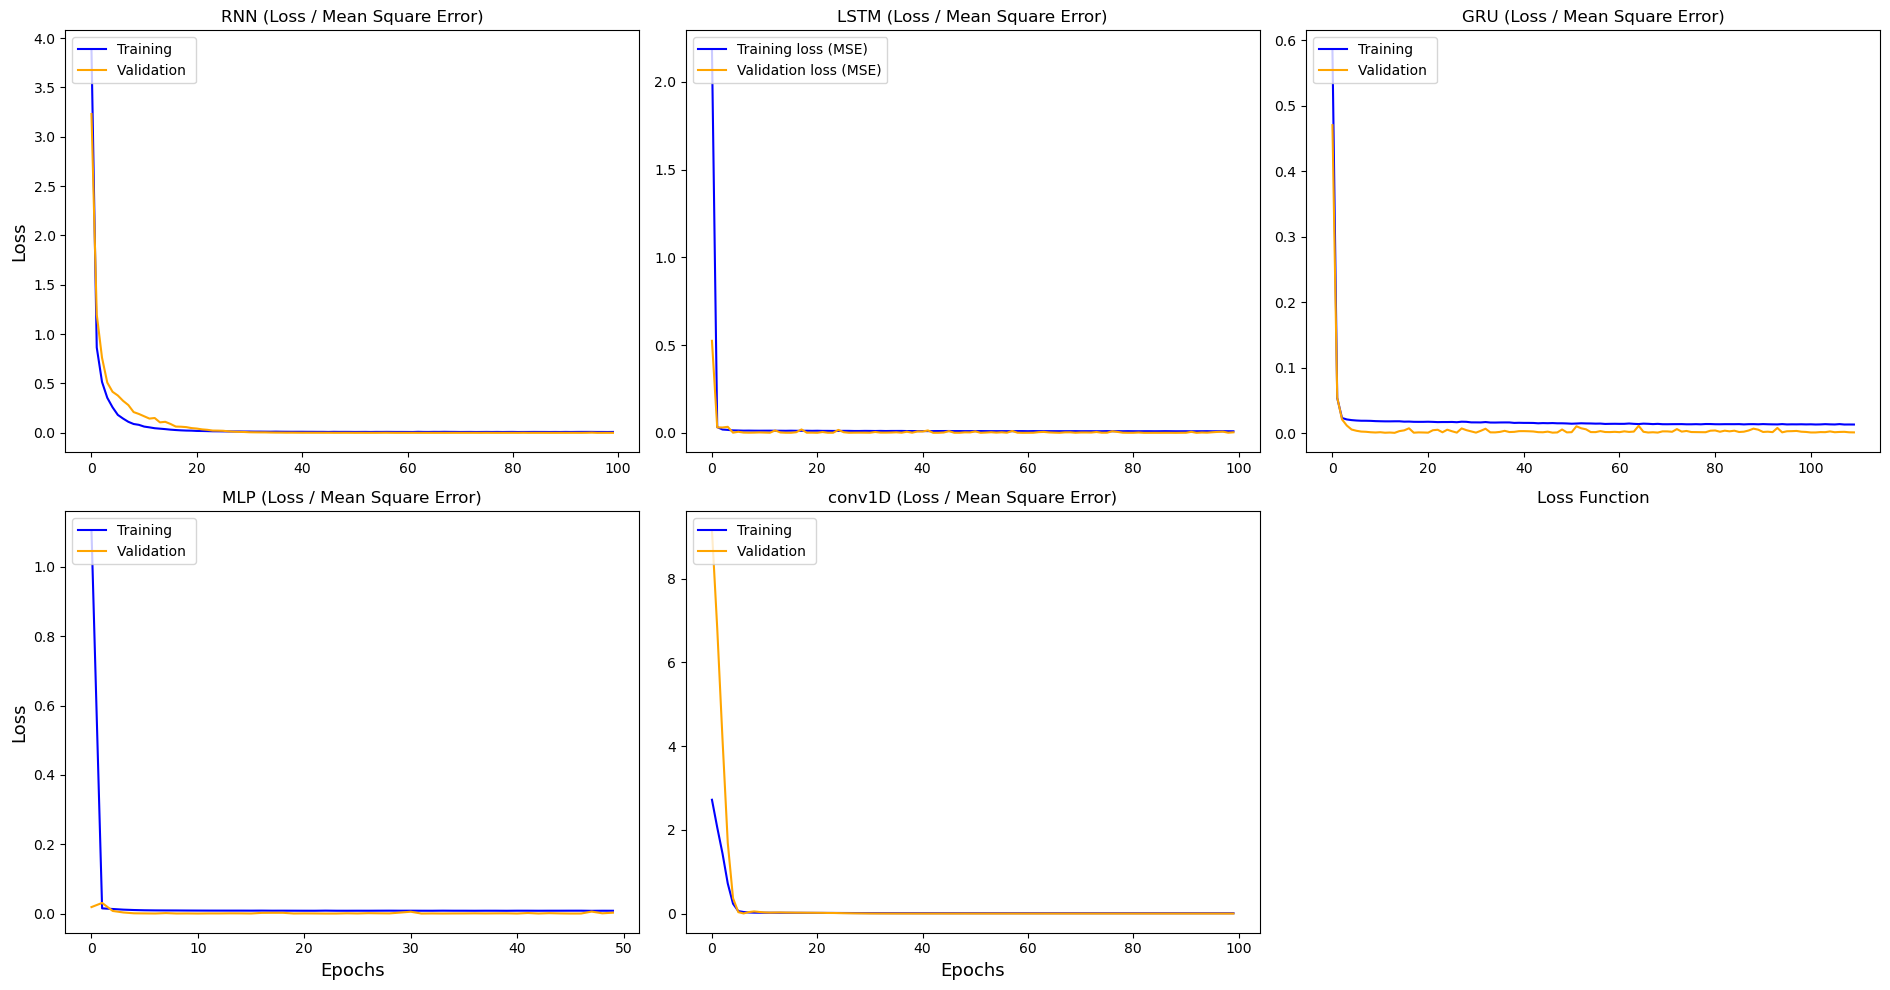

In [170]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,10))

axs[0,0].plot(RNN_df['loss'], label ='Training ', color = 'blue')
axs[0,0].plot(RNN_df['val_loss'], label='Validation ', color = 'orange')
axs[0,0].set_title('RNN (Loss / Mean Square Error)')

axs[0,1].plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
axs[0,1].plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
axs[0,1].set_title('LSTM (Loss / Mean Square Error)')

axs[0,2].plot(GRU_df['loss'], label ='Training ', color = 'blue')
axs[0,2].plot(GRU_df['val_loss'], label='Validation ', color = 'orange')
axs[0,2].set_title('GRU (Loss / Mean Square Error)')

axs[1,0].plot(MLP_df['loss'], label ='Training ', color = 'blue')
axs[1,0].plot(MLP_df['val_loss'], label='Validation ', color = 'orange')
axs[1,0].set_title('MLP (Loss / Mean Square Error)')

axs[1,1].plot(conv1D_df['loss'], label ='Training', color = 'blue')
axs[1,1].plot(conv1D_df['val_loss'], label='Validation ', color = 'orange')
axs[1,1].set_title('conv1D (Loss / Mean Square Error)')

axs[1,2].set_title('Loss Function')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')
#Add legend to all plots
axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Epochs', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('Loss', fontsize=13)
    


    
plt.tight_layout()
plt.savefig('images/Combined3.png', format='png', dpi=1000)
plt.show()


## Combined Plots

In [171]:

# plt.figure(figsize=(19,8))
# plt.plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
# plt.plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
# plt.plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
# plt.plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
# plt.plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
# plt.plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Rate')
# plt.xlabel('Time (days)', fontsize=13)
# plt.ylabel('Loss', fontsize=13)
# plt.legend(fontsize=13)

# plt.savefig('images/Combined1.eps', format='eps', dpi=1000)
# plt.show()

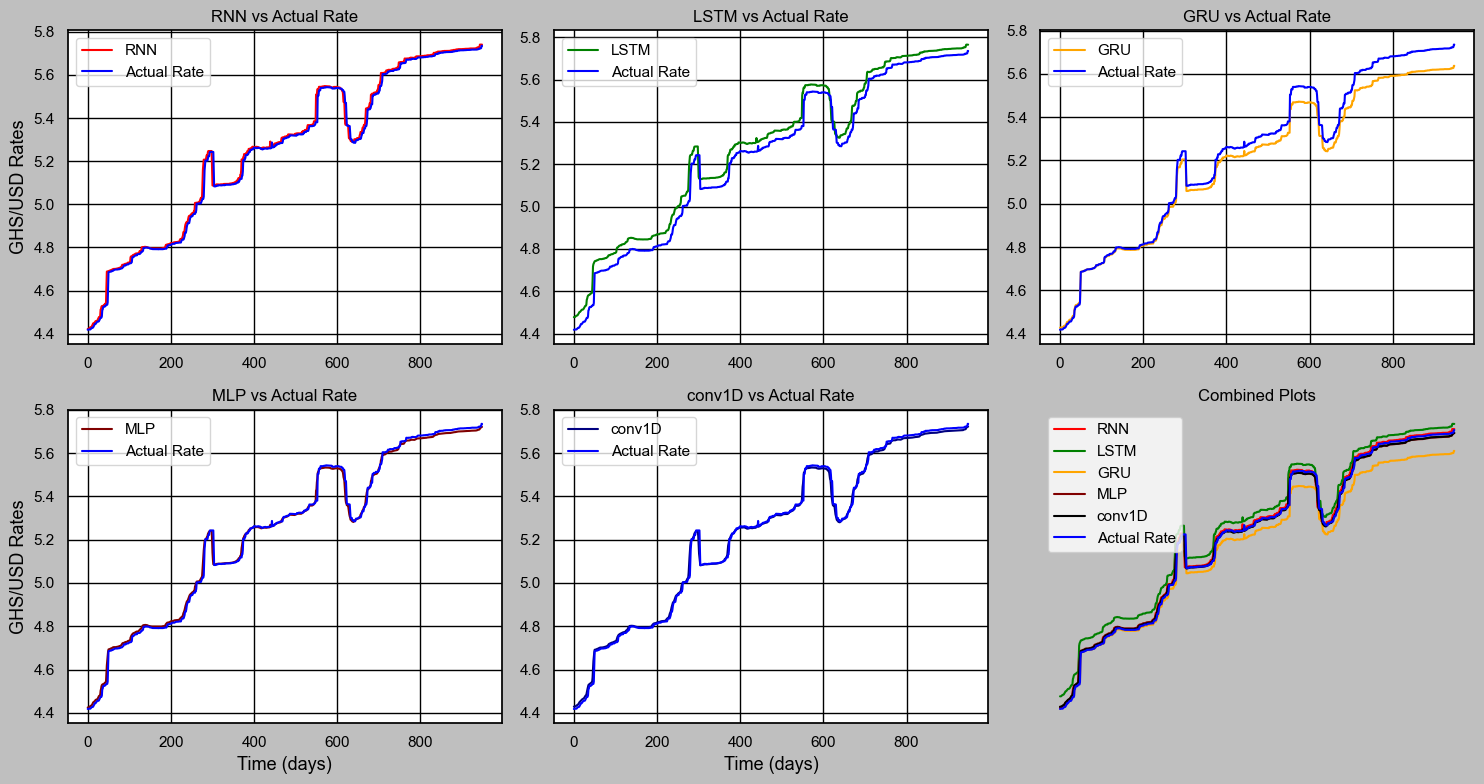

In [211]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

# plt.style.use('grayscale')

axs[0,0].plot(Pred_Data['RNN'], color='red', label='RNN')
axs[0,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[0,0].set_title('RNN vs Actual Rate')

axs[0,1].plot(Pred_Data['LSTM'], color='green', label='LSTM')
axs[0,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[0,1].set_title('LSTM vs Actual Rate')

axs[0,2].plot(Pred_Data['GRU'], color='orange', label='GRU')
axs[0,2].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[0,2].set_title('GRU vs Actual Rate')

axs[1,0].plot(Pred_Data['MLP'], color='maroon', label='MLP')
axs[1,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[1,0].set_title('MLP vs Actual Rate')

axs[1,1].plot(Pred_Data['conv1D'], color='navy', label='conv1D')
axs[1,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[1,1].set_title('conv1D vs Actual Rate')

axs[1,2].plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
axs[1,2].plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
axs[1,2].plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
axs[1,2].plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
axs[1,2].plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
axs[1,2].plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Rate')

axs[1,2].set_title('Combined Plots')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')

axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
axs[1,2].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Time (days)', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('GHS/USD Rates', fontsize=13)
    

plt.tight_layout()
plt.savefig('images/Combined2.png', format='png', dpi=1000)
plt.show()


In [144]:
# plt.figure(figsize=(19,8))
# plt.plot(Pred_Data['RNN'], color='red', label='RNN')
# plt.plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
# plt.xlabel('Time (days)', fontsize=13)
# plt.ylabel('Exchange Rate', fontsize=13)
# plt.title('RNN vs Actual Rate', fontsize=13)
# plt.legend(fontsize=13,loc='upper left', ncol=2)
# plt.show()


In [173]:
# Assuming xtest is the test data and has shape (num_samples, num_timesteps, num_features)
rnn_pred = RNN.predict(xtest)
lstm_pred = LSTM_Model.predict(xtest)
gru_pred = GRU_Model.predict(xtest)
mlp_pred = MLP_Model.predict(xtest)
conv1d_pred = conv1D_Model.predict(xtest)


30/30 [==============================] - 0s 2ms/step


In [174]:
# Combined Models
Pred_Data = pd.DataFrame({
    'RNN': rnn_pred[:,0].flatten(),
    'LSTM': lstm_pred[:,0].flatten(),
    'GRU': gru_pred[:,0].flatten(),
    'MLP': mlp_pred[:,0].flatten(),  # fixed typo here
    'conv1D': conv1d_pred[:,0].flatten(),  # fixed typo here
    'Actual Rate': xtest[:,0].flatten()
})

Pred_Data.head()

,RNN,LSTM,GRU,MLP,conv1D,Actual Rate
0,4.421658,4.477641,4.427310,4.424933,4.428780,4.4179
1,4.421657,4.477709,4.428092,4.424921,4.428984,4.4187
2,4.421658,4.477744,4.428681,4.424894,4.429085,4.4193
3,4.422858,4.478652,4.428681,4.425648,4.429400,4.4193
4,4.425560,4.480831,4.428681,4.427508,4.430480,4.4193


In [175]:
actuals = ytest.reshape(-1, 1)
actuals.shape,Pred_Data.shape

((949, 1), (949, 6))

In [148]:
# print('')
# plt.figure(figsize=(10,5))
# plt.plot(actuals, label="Actual Rate", color = 'blue')
# plt.plot(Pred_Data['RNN'], label="RNN", color = 'red')
# plt.xlabel('Time (days)', fontsize=13)
# plt.ylabel('Rate', fontsize=13)
# plt.legend(fontsize=13)
# plt.show()

In [176]:
# Evaluate RNN predictions
rnn_mae = mean_absolute_error(ytest, Pred_Data['RNN'])
rnn_mse = mean_squared_error(ytest, Pred_Data['RNN'])
rnn_rmse = np.sqrt(rnn_mse)
rnn_r2 = r2_score(ytest, Pred_Data['RNN'])

# Evaluate LSTM predictions
lstm_mae = mean_absolute_error(ytest, Pred_Data['LSTM'])
lstm_mse = mean_squared_error(ytest, Pred_Data['LSTM'])
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(ytest, Pred_Data['LSTM'])

# Evaluate GRU predictions
gru_mae = mean_absolute_error(ytest, Pred_Data['GRU'])
gru_mse = mean_squared_error(ytest, Pred_Data['GRU'])
gru_rmse = np.sqrt(gru_mse)
gru_r2 = r2_score(ytest, Pred_Data['GRU'])

# Evaluate MLP predictions
mlp_mae = mean_absolute_error(ytest, Pred_Data['MLP'])
mlp_mse = mean_squared_error(ytest, Pred_Data['MLP'])
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2 = r2_score(ytest, Pred_Data['MLP'])

# Evaluate Conv1D predictions
conv1d_mae = mean_absolute_error(ytest, Pred_Data['conv1D'])
conv1d_mse = mean_squared_error(ytest, Pred_Data['conv1D'])
conv1d_rmse = np.sqrt(conv1d_mse)
conv1d_r2 = r2_score(ytest, Pred_Data['conv1D'])


In [177]:
print("RNN Evaluation Metrics:")
print(f"MAE: {rnn_mae:.4f}, MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}, R2: {rnn_r2:.4f}\n")

print("LSTM Evaluation Metrics:")
print(f"MAE: {lstm_mae:.4f}, MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, R2: {lstm_r2:.4f}\n")

print("GRU Evaluation Metrics:")
print(f"MAE: {gru_mae:.4f}, MSE: {gru_mse:.4f}, RMSE: {gru_rmse:.4f}, R2: {gru_r2:.4f}\n")

print("MLP Evaluation Metrics:")
print(f"MAE: {mlp_mae:.4f}, MSE: {mlp_mse:.4f}, RMSE: {mlp_rmse:.4f}, R2: {mlp_r2:.4f}\n")

print("Conv1D Evaluation Metrics:")
print(f"MAE: {conv1d_mae:.4f}, MSE: {conv1d_mse:.4f}, RMSE: {conv1d_rmse:.4f}, R2: {conv1d_r2:.4f}\n")


RNN Evaluation Metrics:
MAE: 0.0051, MSE: 0.0001, RMSE: 0.0093, R2: 0.9994

LSTM Evaluation Metrics:
MAE: 0.0398, MSE: 0.0017, RMSE: 0.0413, R2: 0.9876

GRU Evaluation Metrics:
MAE: 0.0537, MSE: 0.0043, RMSE: 0.0653, R2: 0.9691

MLP Evaluation Metrics:
MAE: 0.0107, MSE: 0.0003, RMSE: 0.0162, R2: 0.9981

Conv1D Evaluation Metrics:
MAE: 0.0111, MSE: 0.0003, RMSE: 0.0175, R2: 0.9978



In [152]:
# Create a DataFrame with evaluation metrics
Results = pd.DataFrame({'MAE': [rnn_mae, lstm_mae, gru_mae, mlp_mae, conv1d_mae],
                        'MSE': [rnn_mse, lstm_mse, gru_mse, mlp_mse, conv1d_mse],
                        'RMSE': [rnn_rmse, lstm_rmse, gru_rmse, mlp_rmse, conv1d_rmse],
                        'R2': [rnn_r2, lstm_r2, gru_r2, mlp_r2, conv1d_r2]},
                       
                       index=['RNN', 'LSTM', 'GRU', 'MLP', 'Conv1D'])
Results

,MAE,MSE,RMSE,R2
RNN,0.005054,0.000086,0.009298,0.999373
LSTM,0.088974,0.008782,0.093713,0.936296
GRU,0.040879,0.002476,0.049763,0.982037
MLP,0.010663,0.000264,0.016242,0.998087
Conv1D,0.011088,0.000306,0.017486,0.997782


In [189]:
models = ['RNN', 'LSTM', 'GRU', 'MLP', 'Conv1D']
mae = [0.039535, 0.080556, 0.078681, 0.029373, 0.042233]
mse = [0.002296, 0.008647, 0.010455, 0.001719, 0.003455]
rmse = [0.047919, 0.092991, 0.102249, 0.041463, 0.058780]
r2 = [0.990384, 0.963789, 0.956220, 0.992801, 0.985532]
data = pd.DataFrame({'Model': models, 'MAE': mae, 'MSE': mse, 'RMSE': rmse,'R2':r2})
data

,Model,MAE,MSE,RMSE,R2
0,RNN,0.039535,0.002296,0.047919,0.990384
1,LSTM,0.080556,0.008647,0.092991,0.963789
2,GRU,0.078681,0.010455,0.102249,0.956220
3,MLP,0.029373,0.001719,0.041463,0.992801
4,Conv1D,0.042233,0.003455,0.058780,0.985532


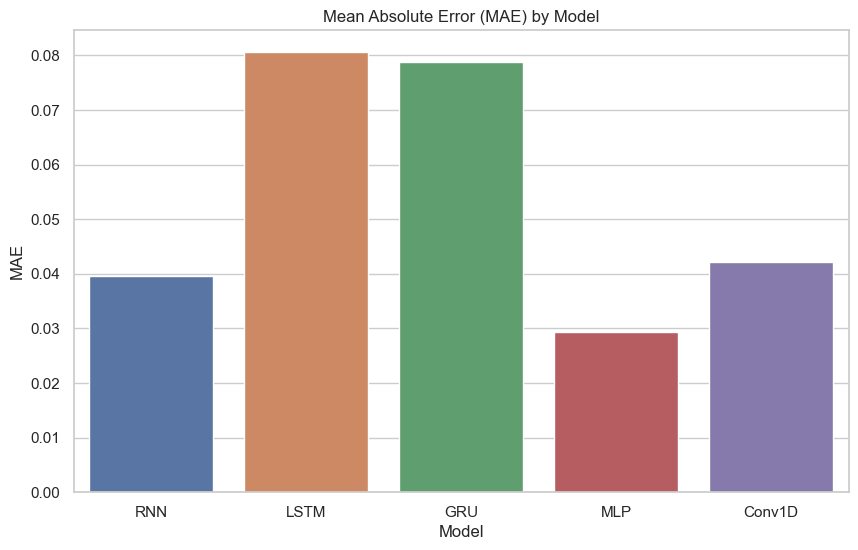

In [181]:
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=data)
plt.title('Mean Absolute Error (MAE) by Model')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.show()


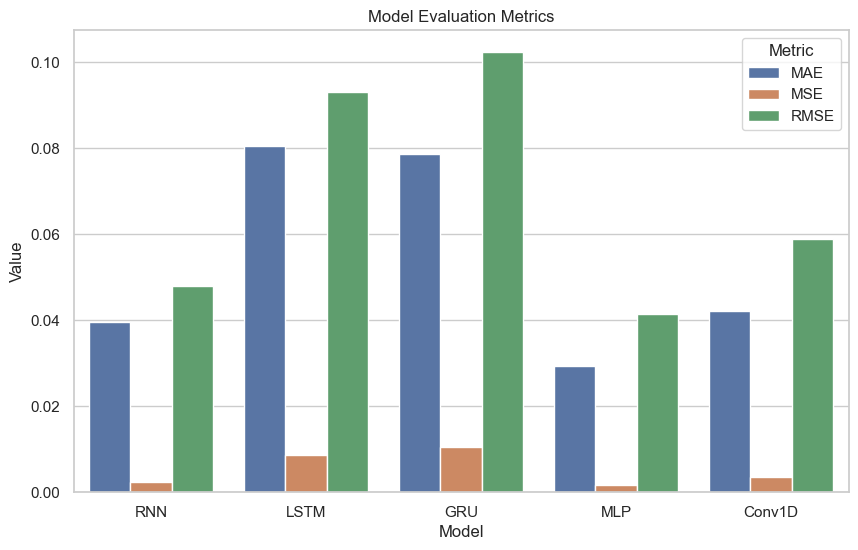

In [186]:
melted_data = data.melt('Model', var_name='Metric', value_name='Value')
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_data)
plt.title('Model Evaluation Metrics')
plt.xlabel('Model')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.show()


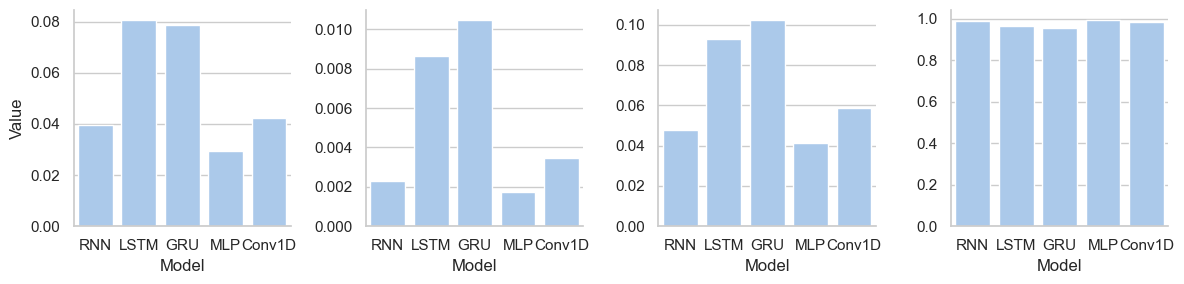

In [204]:
# Melt the DataFrame to convert it into a long format
melted_data = data.melt('Model', var_name='Metric', value_name='Value')

# Plot the metrics in a grid form
sns.set(style='whitegrid', palette='pastel')
g = sns.FacetGrid(melted_data, col='Metric', col_wrap=4, sharey=False)
g.map(sns.barplot, 'Model', 'Value', order=models)
g.set_titles("")

plt.tight_layout()
plt.show()